# Multi-Modal RAG Hands-On Theory Notebook

## What is RAG?

![RAG Image](images/rag.png)

Retrieval-Augmented Generation (RAG) is an AI technique that combines information retrieval with text generation. Instead of relying solely on a pre-trained language model’s internal knowledge, RAG dynamically retrieves relevant documents from an external knowledge base before generating a response.

## Why Rag?

![Why RAG Image](images/why_rag.png)

1. **Improved Accuracy:** RAG enhances the factual correctness of generated responses by retrieving up-to-date and domain-specific information, reducing the likelihood of hallucinations (fabricated information).

2. **Better Generalization:** Since RAG dynamically retrieves relevant documents, it performs well across various domains without requiring extensive fine-tuning, making it more adaptable to new topics.

3. **Reduced Model Size Requirements:** Instead of embedding all knowledge within a large model, RAG leverages external databases, allowing for smaller, more efficient models while maintaining high-quality responses.

4. **Enhanced Explainability:** By referencing retrieved documents, RAG provides verifiable sources for its answers, making it more transparent and easier to trust compared to purely generative models.

5. **And more...**

## What is Multi-modal RAG?

Multi-modal Retrieval-Augmented Generation (RAG) extends the standard RAG approach by incorporating **multiple types of data**—such as text, images, or even audio—**into the retrieval and generation process**. Instead of working with a single modality (like just text), multi-modal RAG systems can query and generate content based on various forms of input, allowing for richer and more diverse responses. 

For example, when dealing with a document that contains both images and text, a multi-modal RAG system can retrieve relevant images along with the associated text, enhancing the quality and relevance of the generated response.


### Text+Images RAG

Multi-modal RAG (Retrieval-Augmented Generation) systems differ in how they handle text and images, depending on whether both the database and the language model (LLM) work with text and images together or focus on one modality. There are a lot of different approaches to reach this goal.

![Multi-Modal RAG Image](images/multi_modal_rag.jpg)

Another approach not shown above is to consider the file as a series of images:
- **File-as-Images** → **Image DB** → **Retrieve Images** → **Multi-modal LLM** → **Text answer and sources**  
- In this case, the document is converted into a series of images (e.g., scanned pages), stored in an image-specific database, and sent as images to a multi-modal LLM, which generates textual answers based on the content of the images. The DB used is usually specialized for this task.

# Hands-on Example

In this exercise, you will learn how to implement a **Multimodal Retrieval-Augmented Generation (RAG)** pipeline from scratch, without relying on tools like `langchain`.  While `langchain` is a powerful framework that simplifies the development of RAG pipelines, it can sometimes lack flexibility for custom implementations, as it abstracts many components.

Here, two different vector store are used to **store the images and text separately**.

The different components of the pipeline are:

- **Text and image extraction from PDFs** – Extract raw text and images from PDF files to make the content processable.  
- **Text and image chunking** – Break the extracted text and images into smaller, meaningful segments to improve retrieval efficiency.  
- **Embedding of the chunks (text and images)** – Convert text and image chunks into numerical representations (embeddings) using pre-trained models.  
- **Storage of the embeddings in a vector store** – Save both text and image embeddings in a specialized database (vector store) to enable fast similarity searches.  
- **Relevant chunks retrieval** – Query the vector store to find the most relevant text and image chunks based on user input.  
- **Setting and prompting of the LLM for a RAG** – Structure prompts and configure the language model to integrate retrieved text and image information into its responses.  
- **Additional tools for improved retrieval** – Use techniques like query expansion to reformulate user queries for better recall and reciprocal rank fusion to combine results from multiple retrieval methods.  
- **Final multimodal RAG pipeline implementation** – Integrate all components into a complete system that retrieves relevant information (both text and images) and generates enhanced responses using the language model.

**Note:** To complete this exercise, you need an OpenAI API key, the PDF files with images, and the necessary libraries installed (see `requirements.txt`).

The example is applied to `Explainable_machine_learning_prediction_of_edema_a.pdf`. Please, have a quick look at it before starting the exercise.

We will try to answer the following question:

In [1]:
test_question = "According to SHAP analysis, which factors were the most influential in predicting higher-grade edema (Grade 2+)?"

## Setup

In [2]:
import sys

sys.path.append("../../")

In [3]:
!pip install -r ../../requirements.txt

In [4]:
import io
import os
import getpass
import json
from tqdm import tqdm

import numpy as np

import base64
import matplotlib.pyplot as plt
from PIL import Image

from helpers.constants_and_data_classes import Chunk, DataType
from helpers.data_processing import PDFExtractor, SimpleChunker
from helpers.embedding import (
    OpenAITextEmbeddings,
    OpenAITextEmbeddingsAzure,
    ImageEmbeddings,
    ImageEmbeddingsForText,
    compute_openai_large_embedding_cost,
)
from helpers.vectorstore import (
    ChromaDBVectorStore,
    VectorStoreRetriever,
)
from helpers.llm import OpenAILLM, OpenAILLMAzure
from helpers.rag import Generator, DefaultRAG

In [5]:
data_folder = "../../data"

example_pdf_file = "Explainable_machine_learning_prediction_of_edema_a.pdf"
example_pdf_path = os.path.join(data_folder, example_pdf_file)

text_vector_store_collection = "text_collection"
image_vector_store_collection = "image_collection"

text_vector_store_full_collection = "text_collection_full"
image_vector_store_full_collection = "image_collection_full"

In [6]:
os.environ["OPENAI_API_KEY"] = getpass.getpass()

## If Azure Endpoint then you don't need the OPENAI_API_KEY but the following
# os.environ["AZURE_API_KEY"] = ""
# os.environ["AZURE_API_BASE"] = ""
# os.environ["AZURE_API_VERSION"] = ""

## LLM  

The LLM is the core of the RAG system, responsible for generating responses based on the retrieved information. There are many options available on-premise or online, each with different performance, speed, specialized knowledge and cost trade-offs.

In this case a **multi-modal LLM is required**, we use `gpt-4o-mini`.  

This LLM expects input in the form of a list of messages, where each message includes the content and the role of the speaker (e.g., developer, user, assistant).  

Images can be provided to this LLM as `base64`, but only when the role is set to `user`.

Here is how messages are defined here:

```python
class Roles(str, Enum):
    DEVELOPER = "developer" # Previously, system
    USER = "user"
    ASSISTANT = "assistant"
    TOOL = "tool"

class LLMMessage(BaseModel):
    content: Optional[str] = None
    role: Optional[Roles] = None
```

In [7]:
# Check if both Azure environment variables exist
azure_endpoint = os.getenv("AZURE_API_BASE")
azure_api_key = os.getenv("AZURE_API_KEY")
if azure_endpoint and azure_api_key:
    llm = OpenAILLMAzure(temperature=0.5)
    print("Using AzureOpenAI client")
else:
    llm = OpenAILLM(temperature=0.5)
    print("Using OpenAI client")

OpenAI LLM loaded: gpt-4o-mini; temperature: 0.5; seed: 42


In [8]:
print(test_question)

According to SHAP analysis, which factors were the most influential in predicting higher-grade edema (Grade 2+)?


In [9]:
answer, price = llm.generate([{"role": "user", "content": test_question}], verbose=True)

Total input tokens: 30
Total output tokens: 442
Total tokens: 472
Estimated cost: $0.0003


In [10]:
print(answer.content)

SHAP (SHapley Additive exPlanations) analysis is a method used to interpret the output of machine learning models by assigning each feature an importance value for a particular prediction. While I don't have access to specific datasets or studies conducted after October 2023, I can provide general guidance on factors that are commonly influential in predicting higher-grade edema (Grade 2+) based on existing literature and clinical knowledge.

Typically, the following factors may be influential in predicting higher-grade edema:

1. **Clinical Factors**: 
   - **Patient's Age**: Older age can be associated with higher edema grades due to decreased vascular and tissue resilience.
   - **Body Mass Index (BMI)**: Higher BMI may correlate with increased tissue pressure and fluid retention.
   - **Underlying Health Conditions**: Conditions such as heart failure, kidney disease, and liver disease can predispose patients to edema.

2. **Treatment-Related Factors**:
   - **Type of Therapy**: Cer

## PDF Text and Images Extraction  

The first step in the pipeline is to extract text and images from the document.  

In this exercise, we use the `MinerU` library, which under the hood uses among others `doclayout_yolo` for segmentation. Note that this model is not commercially permissive.

The choice of extraction tool should be carefully considered. Depending on the document type and formatting, different methods may be required to preserve text integrity and leverage structural elements such as headings, tables, or metadata for better processing (`pdfplumber` (better for tables), `Tesseract OCR` (for scanned PDFs), ect.).

Extracting images can be challenging, as **irrelevant images** (such as logos) are often included, and some images may be **split into multiple images**. It may also be helpful to link the position of images to nearby text for more accurate retrieval. Specialized tools or methods might be required to efficiently handle images embedded in the document.

In [11]:
data_extractor = PDFExtractor()
_, text, images = data_extractor.extract_text_and_images(example_pdf_path)

In [12]:
print(text[:1000])

DOI: [10.1111/cts.70010](https://doi.org/10.1111/cts.70010)

### **ARTICLE**

![](_page_0_Picture_4.jpeg)

# **Explainable machine learning prediction of edema adverse events in patients treated with tepotinib**

**Federico Amato[1](#page-0-0)** | **Rainer Strotmann[2](#page-0-1)** | **Roberto Castell[o1](#page-0-0)** | **Rolf Bruns[2](#page-0-1)** | **Vishal Ghori[3](#page-0-2)** | **Andreas John[e2](#page-0-1)** | **Karin Berghoff[2](#page-0-1)** | **Karthik Venkatakrishna[n4](#page-0-3)** | **Nadia Terranova[5](#page-0-4)**

<span id="page-0-0"></span>1 Swiss Data Science Center (EPFL and ETH Zurich), Lausanne, Switzerland

<span id="page-0-1"></span>2 The healthcare business of Merck KGaA, Darmstadt, Germany

<span id="page-0-2"></span>3 Ares Trading S.A., Eysins, Switzerland, an affiliate of Merck KGaA, Darmstadt, Germany

<span id="page-0-3"></span>4 EMD Serono, Billerica, Massachusetts, USA

<span id="page-0-4"></span>5 Quantitative Pharmacology, Ares Trading S.A., Lausanne, Swi

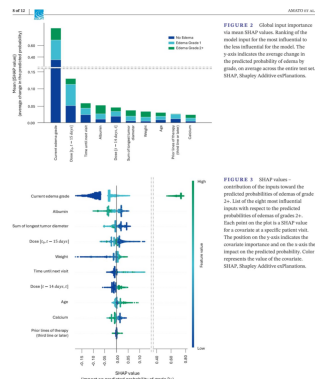

In [13]:
img_data = base64.b64decode(images[2]["image_base64"])
img = Image.open(io.BytesIO(img_data))

plt.imshow(img)
plt.axis("off")
plt.show()

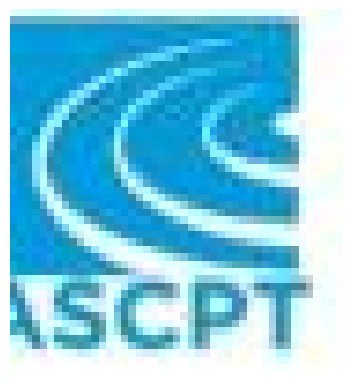

In [14]:
img_data = base64.b64decode(images[0]["image_base64"])
img = Image.open(io.BytesIO(img_data))

plt.imshow(img)
plt.axis("off")
plt.show()

## Chunking

The second step is to split the extracted text into smaller chunks, which will later be embedded and retrieved efficiently. 

In this exercise, we use a simple heuristic approach: the text is split iteratively—first by heading levels (`#`), then by line breaks (`\n`), and finally by sentence (`.`). Splitting only occurs if the resulting chunk exceeds a predefined length. However, more advanced techniques exist, such as **semantic chunking** (which splits based on meaning rather than syntax) or **agentic chunking** (which dynamically adapts chunk sizes based on context).

**Images are treated as separate chunks**, but with a different `DataType`. Additional relevant metadata can also be included, such as the image's position relative to the text or its caption, if available. They are stored in another list.

Each chunk is enriched with metadata, including:  
- **Source file** – The document from which the chunk originates.  
- **Chunk counter** – The position of the chunk within the file.  
- **Unique identifier (`chunk_id`)** – Ensures each chunk can be referenced independently.  
- **Data type** - The document type (image or text).

Additional metadata could be included to enable more refined filtering and retrieval strategies.  

```python
class DataType(str, Enum):
    TEXT = "text"
    IMAGE = "image"


class Chunk(BaseModel):
    chunk_id: int
    content: str
    metadata: dict = Field(default_factory=dict)
    data_type: Optional[DataType] = None
    score: Optional[float] = None
```


In [15]:
chunker = SimpleChunker()
text_chunks = chunker.chunk_text(text, {"source_text": example_pdf_file})
image_chunks = chunker.chunk_images(images, {"source_text": example_pdf_file})

In [16]:
print(len(text_chunks))
text_chunks[0]

62


Chunk(chunk_id=0, content='DOI: [10.1111/cts.70010](https://doi.org/10.1111/cts.70010) ### **ARTICLE** ![](_page_0_Picture_4.jpeg) # **Explainable machine learning prediction of edema adverse events in patients treated with tepotinib** **Federico Amato[1](#page-0-0)** | **Rainer Strotmann[2](#page-0-1)** | **Roberto Castell[o1](#page-0-0)** | **Rolf Bruns[2](#page-0-1)** | **Vishal Ghori[3](#page-0-2)** | **Andreas John[e2](#page-0-1)** | **Karin Berghoff[2](#page-0-1)** | **Karthik Venkatakrishna[n4](#page-0-3)** | **Nadia Terranova[5](#page-0-4)** <span id="page-0-0"></span>1 Swiss Data Science Center (EPFL and ETH Zurich), Lausanne, Switzerland <span id="page-0-1"></span>2 The healthcare business of Merck KGaA, Darmstadt, Germany <span id="page-0-2"></span>3 Ares Trading S.A., Eysins, Switzerland, an affiliate of Merck KGaA, Darmstadt, Germany <span id="page-0-3"></span>4 EMD Serono, Billerica, Massachusetts, USA', metadata={'source_text': 'Explainable_machine_learning_prediction_of

4


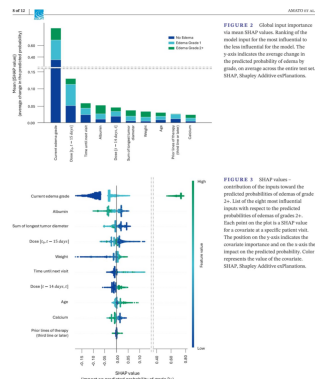

In [17]:
print(len(image_chunks))

img_data = base64.b64decode(image_chunks[2].content)
img = Image.open(io.BytesIO(img_data))

plt.imshow(img)
plt.axis("off")
plt.show()

## Embedding Models  

Once the text and images are divided into chunks, each chunk is converted into a numerical representation (embedding) that captures its meaning.  

For text, we use OpenAI’s `text-embedding-3-large`, but other options exist, each with different trade-offs in on-premise vs online, accuracy, speed, and cost. The choice of model depends on the specific needs of the retrieval task.

For images, we utilize `VLM2Vec`. Similar to text embeddings, various options exist for image embeddings, each with its own trade-offs. There will be one embedding model to convert images to vector representation, and another to convert the user query into the same representation.

In [18]:
_ = compute_openai_large_embedding_cost(text_chunks, verbose=True)


# Check if both Azure environment variables exist
azure_endpoint = os.getenv("AZURE_API_BASE")
azure_api_key = os.getenv("AZURE_API_KEY")
if azure_endpoint and azure_api_key:
    text_embedding_model = OpenAITextEmbeddingsAzure()
    print("Using AzureOpenAI client")
else:
    text_embedding_model = OpenAITextEmbeddings()
    print("Using OpenAI client")

    
text_embeddings = text_embedding_model.get_embedding(
    [chunk.content for chunk in text_chunks]
)

print(text_embeddings.shape)
text_embeddings[0]

Total tokens: 13665
Estimated cost: $0.0018
(62, 3072)


array([-0.03139326,  0.00624392, -0.01343889, ...,  0.00983313,
        0.00327495, -0.0014607 ], shape=(3072,))

In [19]:
image_embeddings = []

image_embedding_model = ImageEmbeddings()
for chunk in tqdm(image_chunks):
    image_embeddings.append(image_embedding_model.get_embedding(chunk.content))


image_embeddings = np.array(image_embeddings)

100%|██████████| 4/4 [00:06<00:00,  1.74s/it]


In [20]:
# Also define the text embedding for the image-text embedding model
image_text_embedding_model = ImageEmbeddingsForText()

## Vector Store and Retrieval  

After embedding the chunks, they need to be stored for efficient retrieval. The choice of vector store depends on factors like accuracy, speed, and filtering options. In this exercise, we use `ChromaDB`.  

The next step is retrieving the most relevant chunks based on a query. In this implementation, the retriever uses only embeddings (sparse search). However, in some cases, dense search methods like BM25 or hybrid approaches combining both sparse and dense search can be used for better accuracy when retrieving the text. Some retrieval strategies also use the metadata.

Text and image embeddings are stored separately here, thus their similarities cannot be directly compared. As a consequence, the retrieval strategy implemented here is to take the `top_k` for each datatype.


In [21]:
vector_store_text = ChromaDBVectorStore(text_vector_store_collection)
vector_store_text.insert_chunks(text_chunks, text_embeddings)

In [22]:
vector_store_image = ChromaDBVectorStore(image_vector_store_collection)
vector_store_image.insert_chunks(image_chunks, image_embeddings)

In [23]:
retriever = VectorStoreRetriever(
    text_embedding_model,
    vector_store_text,
    image_text_embedding_model,
    vector_store_image,
)

results = retriever.retrieve(test_question, top_k_text=5, top_k_image=1)

{'chunk_id': '39', 'score': 0.5415405035018921, 'chunk': Chunk(chunk_id=39, content='Points are colored based on the edema grade at the following safety visit. SHAP, Shapley Additive exPlanations. with higher grades of edema, particularly grade 2+. On the other hand, for higher albumin levels the corresponding SHAP values are mostly negative and ranging from 0 to −0.5, suggesting a reduced risk of edema of grade 2+. The association between age greater than 70years and an increased likelihood of edemas of grades 2+ was also confirmed. Additionally, for all ages, higher SHAP values were assigned to patients who experienced edemas, particularly of grade 2+. Finally, within low ranges of cumulated dose in the interval [ *t* − 14 days, *t* ] normalized over 14days, higher SHAP values were assigned to samples corresponding to edemas of grades 2+. This could reflect the tendency to adjust administered doses in those cases where the risk of edema was identified. # **DISCUSSION**', metadata={'s

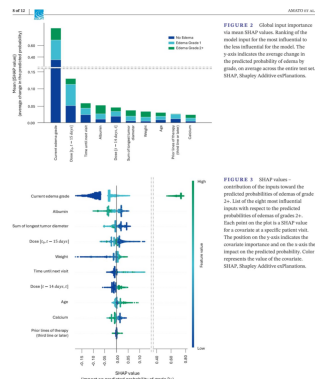

In [24]:
for result_l in results:
    for result in result_l:
        if result["chunk"].data_type == DataType.TEXT:
            print(result)
        elif result["chunk"].data_type == DataType.IMAGE:
            print(f"Chunk ID: {result['chunk_id']} | Score: {result['score']}")
            img_data = base64.b64decode(result["chunk"].content)
            img = Image.open(io.BytesIO(img_data))
            plt.imshow(img)
            plt.axis("off")
            plt.show()

## Generator  

Once the LLM is set up, a specific prompt needs to be defined for the RAG system. This prompt must include the retrieved chunks as context. The prompt has to be adapted to each specific project.

In addition to the basic prompt, we incorporate **prompt engineering** by asking the LLM to justify its answer. The model is also instructed to indicate which chunks were most relevant in forming its response, improving **interpretability**, and to provide the answer in **JSON format** for easier data management.

In [25]:
default_developer_prompt = """You are a helpful assistant, and your task is to answer questions using relevant chunks and images. Please first think step-by-step by mentioning which chunks you used and then answer the question. Organize your output in a json formatted as dict{"step_by_step_thinking": Str(explanation), "chunk_used": List(integers), "answer": Str{answer}}. Your responses will be read by someone without specialized knowledge, so please have a definite and concise answer."""
print(default_developer_prompt)

You are a helpful assistant, and your task is to answer questions using relevant chunks and images. Please first think step-by-step by mentioning which chunks you used and then answer the question. Organize your output in a json formatted as dict{"step_by_step_thinking": Str(explanation), "chunk_used": List(integers), "answer": Str{answer}}. Your responses will be read by someone without specialized knowledge, so please have a definite and concise answer.


In [26]:
default_rag_template = """
Here are the relevant CHUNKS:
{context}

--------------------------------------------

Here is the USER QUESTION:
{query}

--------------------------------------------

Please think step-by-step and generate your output in json:
"""
print(default_rag_template)


Here are the relevant CHUNKS:
{context}

--------------------------------------------

Here is the USER QUESTION:
{query}

--------------------------------------------

Please think step-by-step and generate your output in json:



In [27]:
generator = Generator(llm, default_developer_prompt, default_rag_template)

You are a helpful assistant, and your task is to answer questions using relevant chunks and images. Please first think step-by-step by mentioning which chunks you used and then answer the question. Organize your output in a json formatted as dict{"step_by_step_thinking": Str(explanation), "chunk_used": List(integers), "answer": Str{answer}}. Your responses will be read by someone without specialized knowledge, so please have a definite and concise answer.

Here are the relevant CHUNKS:


Chunk 1: 
Image from chunk 1 attached in next messages.

Chunk 2: 
DOI: [10.1111/cts.70010](https://doi.org/10.1111/cts.70010) ### **ARTICLE** ![](_page_0_Picture_4.jpeg) # **Explainable machine learning prediction of edema adverse events in patients treated with tepotinib** **Federico Amato[1](#page-0-0)** | **Rainer Strotmann[2](#page-0-1)** | **Roberto Castell[o1](#page-0-0)** | **Rolf Bruns[2](#page-0-1)** | **Vishal Ghori[3](#page-0-2)** | **Andreas John[e2](#page-0-1)** | **Karin Berghoff[2](#pag

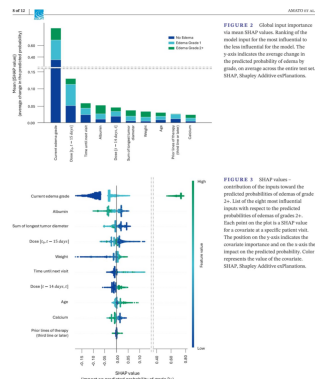

Total input tokens: 26025
Total output tokens: 196
Total tokens: 26221
Estimated cost: $0.0040


In [28]:
answer, cost = generator.generate(
    history=[],
    query=test_question,
    chunks=[
        Chunk(
            chunk_id=0,
            data_type=DataType.IMAGE,
            content=image_chunks[2].content,
            metadata={},
        ),
        Chunk(
            chunk_id=1,
            data_type=DataType.TEXT,
            content=text_chunks[0].content,
            metadata={},
        ),
    ],
    verbose=True,
)

In [29]:
print(answer.content)

```json
{
  "step_by_step_thinking": "I analyzed the provided image from chunk 1, which contains SHAP values indicating the influence of various factors on predicting higher-grade edema (Grade 2+). The factors are ranked based on their mean SHAP values, with 'Current edema grade' being the most influential, followed by 'Albumin', 'Sum of longest tumor diameter', 'Dose', 'Weight', 'Time until next visit', 'Age', and 'Calcium'. These insights were derived from the visual representation of the data in the image.",
  "chunk_used": [1],
  "answer": "The most influential factors in predicting higher-grade edema (Grade 2+) according to SHAP analysis are: 1. Current edema grade 2. Albumin 3. Sum of longest tumor diameter 4. Dose 5. Weight 6. Time until next visit 7. Age 8. Calcium."
}
```


In [30]:
print(cost)

0.00402135


## RAG "Tricks"  

There are several methods to improve the efficiency of a RAG pipeline, such as query contextualization, query reformulation, re-ranking, query expansion, etc. For the sake of time, none of those has been implemented here.

## RAG  

Finally, the RAG pipeline is defined by integrating all the previously discussed components into a unified process.

## Only with text

In [31]:
rag_without_images = DefaultRAG(
    llm=llm,
    text_embedding_model=text_embedding_model,
    text_vector_store=vector_store_text,
    generator=generator,
    params={"top_k_text": 5},
)

In [32]:
print(test_question)

According to SHAP analysis, which factors were the most influential in predicting higher-grade edema (Grade 2+)?


In [33]:
answer, sources, cost = rag_without_images.execute(test_question, {}, verbose=True)

You are a helpful assistant, and your task is to answer questions using relevant chunks and images. Please first think step-by-step by mentioning which chunks you used and then answer the question. Organize your output in a json formatted as dict{"step_by_step_thinking": Str(explanation), "chunk_used": List(integers), "answer": Str{answer}}. Your responses will be read by someone without specialized knowledge, so please have a definite and concise answer.

Here are the relevant CHUNKS:


Chunk 1: 
Points are colored based on the edema grade at the following safety visit. SHAP, Shapley Additive exPlanations. with higher grades of edema, particularly grade 2+. On the other hand, for higher albumin levels the corresponding SHAP values are mostly negative and ranging from 0 to −0.5, suggesting a reduced risk of edema of grade 2+. The association between age greater than 70years and an increased likelihood of edemas of grades 2+ was also confirmed. Additionally, for all ages, higher SHAP va

In [34]:
print(json.dumps(answer, indent=3))

{
   "step_by_step_thinking": "To answer the question, I reviewed the chunks to identify the factors influencing higher-grade edema (Grade 2+). From Chunk 1, it mentions that higher albumin levels are associated with reduced risk of edema of grade 2+, while age greater than 70 years is linked to increased likelihood of higher-grade edema. Chunk 2 emphasizes that past current edema grade is the most influential input for predicting future edema grades. Additionally, it highlights that albumin is the most informative time-varying covariate for predicting edemas of grades 2+. Chunk 4 provides insights into the SHAP values and their contributions to predicting probabilities of edemas of grades 2+. Overall, the most influential factors identified are past edema grade, age, and albumin levels.",
   "chunk_used": [
      1,
      2,
      4
   ],
   "answer": "The most influential factors in predicting higher-grade edema (Grade 2+) according to SHAP analysis are the past current edema grade, 

In [35]:
# The chunks retrieved by the retriever:
print(len(sources))
print(sources[0])

5
{'chunk_id': '39', 'chunk': Chunk(chunk_id=39, content='Points are colored based on the edema grade at the following safety visit. SHAP, Shapley Additive exPlanations. with higher grades of edema, particularly grade 2+. On the other hand, for higher albumin levels the corresponding SHAP values are mostly negative and ranging from 0 to −0.5, suggesting a reduced risk of edema of grade 2+. The association between age greater than 70years and an increased likelihood of edemas of grades 2+ was also confirmed. Additionally, for all ages, higher SHAP values were assigned to patients who experienced edemas, particularly of grade 2+. Finally, within low ranges of cumulated dose in the interval [ *t* − 14 days, *t* ] normalized over 14days, higher SHAP values were assigned to samples corresponding to edemas of grades 2+. This could reflect the tendency to adjust administered doses in those cases where the risk of edema was identified. # **DISCUSSION**', metadata={'source_text': 'Explainable_m

In [36]:
print(cost)

0.00031095


## With text and images

In [37]:
rag = DefaultRAG(
    llm=llm,
    text_embedding_model=text_embedding_model,
    text_vector_store=vector_store_text,
    image_text_embedding_model=image_text_embedding_model,
    image_vector_store=vector_store_image,
    generator=generator,
    params={"top_k_text": 5, "top_k_image": 1},
)

In [38]:
print(test_question)

According to SHAP analysis, which factors were the most influential in predicting higher-grade edema (Grade 2+)?


You are a helpful assistant, and your task is to answer questions using relevant chunks and images. Please first think step-by-step by mentioning which chunks you used and then answer the question. Organize your output in a json formatted as dict{"step_by_step_thinking": Str(explanation), "chunk_used": List(integers), "answer": Str{answer}}. Your responses will be read by someone without specialized knowledge, so please have a definite and concise answer.

Here are the relevant CHUNKS:


Chunk 1: 
Points are colored based on the edema grade at the following safety visit. SHAP, Shapley Additive exPlanations. with higher grades of edema, particularly grade 2+. On the other hand, for higher albumin levels the corresponding SHAP values are mostly negative and ranging from 0 to −0.5, suggesting a reduced risk of edema of grade 2+. The association between age greater than 70years and an increased likelihood of edemas of grades 2+ was also confirmed. Additionally, for all ages, higher SHAP va

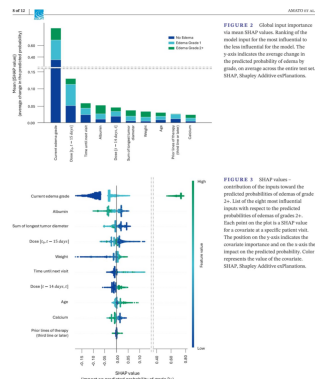

Total input tokens: 26709
Total output tokens: 228
Total tokens: 26937
Estimated cost: $0.0041


In [39]:
answer, sources, cost = rag.execute(test_question, {}, verbose=True)

In [40]:
print(json.dumps(answer, indent=3))

{
   "step_by_step_thinking": "To identify the most influential factors predicting higher-grade edema (Grade 2+), I analyzed the provided chunks and the attached image. Chunk 1 and Chunk 2 highlight the significance of the current edema grade and albumin levels. The image (Figure 2 and Figure 3) explicitly ranks the input variables based on their SHAP values, showing that 'Current edema grade' and 'Albumin' are at the top of the list, indicating their strong influence on predicting Grade 2+ edema. Additionally, other factors such as 'Time until next visit' and 'Age' are also noted as influential. Therefore, the key factors are confirmed by both the textual analysis and the visual data representation.",
   "chunk_used": [
      1,
      2,
      4,
      6
   ],
   "answer": "The most influential factors in predicting higher-grade edema (Grade 2+) according to SHAP analysis are: 1) Current edema grade, 2) Albumin levels, 3) Time until next visit, and 4) Age."
}


In [41]:
# The chunks retrieved by the retriever:
print(len(sources))
print(sources[0])

6
{'chunk_id': '39', 'chunk': Chunk(chunk_id=39, content='Points are colored based on the edema grade at the following safety visit. SHAP, Shapley Additive exPlanations. with higher grades of edema, particularly grade 2+. On the other hand, for higher albumin levels the corresponding SHAP values are mostly negative and ranging from 0 to −0.5, suggesting a reduced risk of edema of grade 2+. The association between age greater than 70years and an increased likelihood of edemas of grades 2+ was also confirmed. Additionally, for all ages, higher SHAP values were assigned to patients who experienced edemas, particularly of grade 2+. Finally, within low ranges of cumulated dose in the interval [ *t* − 14 days, *t* ] normalized over 14days, higher SHAP values were assigned to samples corresponding to edemas of grades 2+. This could reflect the tendency to adjust administered doses in those cases where the risk of edema was identified. # **DISCUSSION**', metadata={'source_text': 'Explainable_m

In [42]:
print(cost)

0.00414315


----------------